inputs: data generated by 0_eda.ipynb

contents: model training scripts

output: the "best" model written to best_model/ (used in the streamlit dashboard)

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

df = pd.read_csv('data/model_ready.csv')
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,label
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


Training set size: 616 samples
Test set size: 304 samples

Class distribution before resampling:
label
0    275
1    177
2     73
3     72
4     19
Name: count, dtype: int64

Class distribution after resampling:
0    275
1    275
2    275
3    275
4    275
Name: count, dtype: int64
100%|██████████| 100/100 [08:29<00:00,  5.10s/trial, best loss: -0.9078114222290596]

Classification Metrics:
Accuracy Score: 0.6217

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       136
           1       0.59      0.55      0.57        88
           2       0.40      0.47      0.44        36
           3       0.31      0.29      0.30        35
           4       0.00      0.00      0.00         9

    accuracy                           0.62       304
   macro avg       0.42      0.43      0.42       304
weighted avg       0.61      0.62      0.61       304



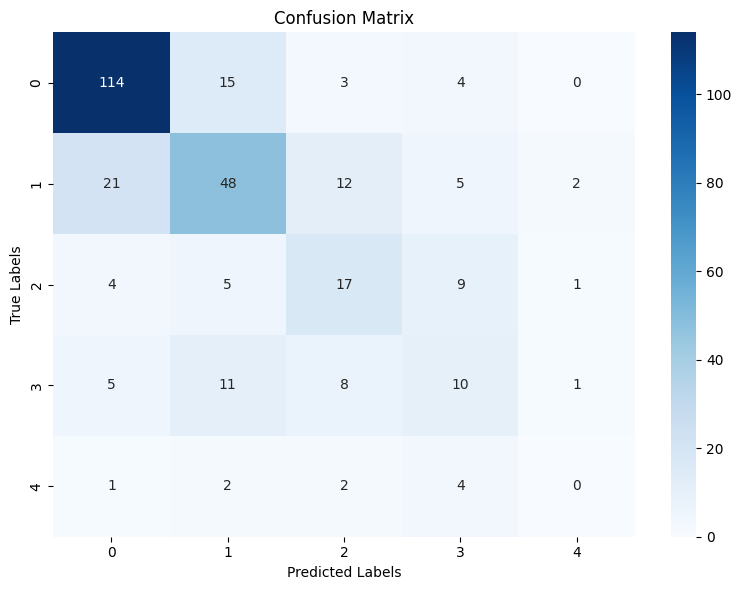

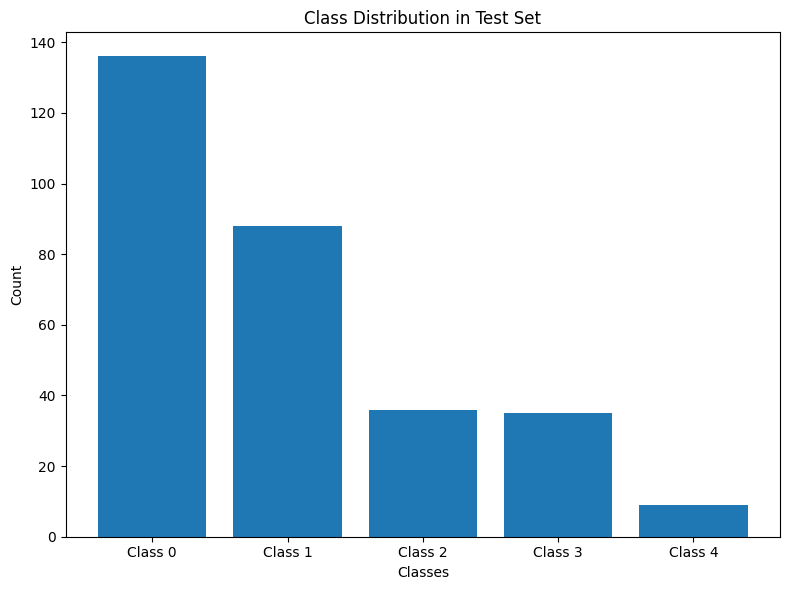

In [7]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]

class DataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoders = {}

    def fit(self, X, y=None):
        # Convert all columns to string type to avoid type comparison issues
        X = X.astype(str)
        # Handle missing values and encode categorical columns
        categorical_cols = X.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].fillna(X[col].mode()[0]))
            self.encoders[col] = le
        return self

    def transform(self, X):
        X = X.copy()
        # Convert all columns to string type to avoid type comparison issues
        X = X.astype(str)
        # Handle missing values in numeric columns
        numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
        for col in numeric_cols:
            X[col] = X[col].fillna(X[col].median())

        # Encode categorical columns
        for col, le in self.encoders.items():
            # Fit the encoder with all possible labels including those in the test set
            all_labels = np.unique(X[col].fillna(X[col].mode()[0]))
            le.classes_ = np.unique(np.concatenate((le.classes_, all_labels), axis=None))
            X[col] = le.transform(X[col].fillna(X[col].mode()[0]))
        return X


# Split the data into features and target
X = df.drop('label', axis=1).drop('id', axis=1)
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
# Print train/test set sizes
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Resample the training data to balance classes
from sklearn.utils import resample

# Get the class counts
class_counts = pd.Series(y_train).value_counts()
# Get the maximum class count to upsample other classes to
max_samples = class_counts.max()

# Initialize resampled data arrays
X_train_resampled = pd.DataFrame()
y_train_resampled = pd.Series()

# Resample each class to have the same number of samples
for class_label in class_counts.index:
    # Get samples for this class
    X_class = X_train[y_train == class_label]
    y_class = y_train[y_train == class_label]
    
    # Resample with replacement if needed
    if len(X_class) < max_samples:
        X_resampled, y_resampled = resample(X_class, 
                                          y_class,
                                          replace=True,
                                          n_samples=max_samples,
                                          random_state=42)
    else:
        X_resampled, y_resampled = X_class, y_class
    
    # Append to resampled datasets
    X_train_resampled = pd.concat([X_train_resampled, X_resampled])
    y_train_resampled = pd.concat([y_train_resampled, y_resampled])

# Print the original and new class distributions
print("\nClass distribution before resampling:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nClass distribution after resampling:")
print(pd.Series(y_train_resampled).value_counts().sort_index())




# Define the search space for hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

def objective(params):
    pipeline = Pipeline([
        ('selector', DataFrameSelector(df.columns.drop('label').drop('id'))),
        ('preprocessor', DataPreprocessor()),
        ('regressor', xgb.XGBClassifier(
            use_label_encoder=False,
            **params
        ))
    ])
    
    # Use cross validation to evaluate the model with f1 score
    score = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=5, scoring='f1_weighted')
    
    # Return the negative f1 score (hyperopt minimizes)
    return {'loss': -score.mean(), 'status': STATUS_OK}

space = {
    'max_depth': hp.choice('max_depth', range(3, 11)),
    'min_child_weight': hp.uniform('min_child_weight', 0.5, 5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.1)),
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500]),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

# Create and fit the final pipeline with best parameters
best_params = {
    'max_depth': best['max_depth'] + 3,  # Adjust for hp.choice offset
    'min_child_weight': best['min_child_weight'],
    'learning_rate': best['learning_rate'],
    'n_estimators': [100, 200, 300, 400, 500][best['n_estimators']],  # Adjust for hp.choice
    'gamma': best['gamma'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree']
}

pipeline = Pipeline([
    ('selector', DataFrameSelector(df.columns.drop('label').drop('id'))),
    ('preprocessor', DataPreprocessor()),
    ('regressor', xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        **best_params
    ))
])

# Fit the pipeline with best parameters
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Calculate and print evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate classification metrics
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nClassification Metrics:")
print(f"Accuracy Score: {accuracy:.4f}")
print("\nClassification Report:")
print(class_report)

# Create confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Create bar plot of class distribution
plt.figure(figsize=(8, 6))
unique, counts = np.unique(y_test, return_counts=True)
plt.bar(['Class ' + str(c) for c in unique], counts)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution in Test Set')
plt.tight_layout()
plt.show()


In [10]:
import mlflow
import shutil

# Reset indices of X_train and y_train
X_train = X_train.reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)

# Sample 100 rows from X_train and y_train
X_train_sample = X_train.sample(n=100, random_state=42)
y_train_sample = y_train[X_train_sample.index]

# Remove the existing 'best_model' directory if it exists
shutil.rmtree('best_classification_model', ignore_errors=True)

# Infer the signature of the model based on the sample data
signature = mlflow.models.signature.infer_signature(X_train_sample, y_train_sample)

# Save the trained model to the 'best_model' directory with the inferred signature
mlflow.sklearn.save_model(pipeline, 'best_classification_model', signature=signature, input_example=X_test)

In [11]:
test_df = pd.DataFrame(X_test)
test_df['label'] = y_test
test_df.to_csv('data/test_df.csv', index=False)